This is a script to access data from the Google Earth Engine.

In [ ]:
# Working with earth engine (ee)
import ee
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=FgqM6XxEw0ws3j-ff-KGFQfX8PKyQXwhQ8yM8kC26hw&tc=REn19kbmt6FjbihK4NkVjp-VF3fzweVLdtuFgjVG7U4&cc=MWB5UCRUKy5fmQKXzHbC80y3R4PbT1CXJW7_ciLYD_0

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VNERiFxZxH1FK9iiwFsFeY4b-Pj5mtryMjRtF2o329lFjj2fj576RU

Successfully saved authorization token.


Token authorization provided. Now, what data do we want?

In [ ]:
# Import the ERA5 C collection.
# Daily Aggregates - Latest Climate Reanalysis Produced by ECMWF / Copernicus Climate Change Service
# https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY#bands
lst = ee.ImageCollection('MODIS/061/MOD11A1')

Data source: [ERA5 Daily Aggregates](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_DAILY#bands)
**Data source: [MOD11A1.061 Terra Land Surface Temperature and Emissivity Daily Global](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A1#bands)**

Select only the data within the dates we want.

In [ ]:
# Initial date of interest (inclusive).
i_date = '2000-02-24'

# Final date of interest (exclusive).
f_date = '2023-04-28'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

Let's take a look at Madison, WI. We can specify the coords by lat and lon.

In [ ]:
# Define the location of interest
# Madison WI
# lon = -89.40123019999999
# lat = 43.0730517
u_lon = -89.4012
u_lat = 43.0730
u_poi = ee.Geometry.Point(u_lon, u_lat)

Define the scale we want in meters and then calculate the average temp at the point.

In [ ]:
scale = 1000  # scale in meters

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

Average daytime LST at urban point: 16.98 °C


We got it going now. Let's look at the first 5 points.  



In [ ]:
# Get the data for the pixel intersecting the point in urban area.
lst_u_poi = lst.getRegion(u_poi, scale).getInfo()
# Preview the result.
lst_u_poi[:5]

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2000_02_24', -89.40482865199539, 43.06972629711046, 951350400000, None, 2],
 ['2000_02_25', -89.40482865199539, 43.06972629711046, 951436800000, None, 2],
 ['2000_02_26', -89.40482865199539, 43.06972629711046, 951523200000, None, 2],
 ['2000_02_27', -89.40482865199539, 43.06972629711046, 951609600000, 14151, 0]]

Convert that to a pandas data frame to make it easier to work with.

In [ ]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

Look at the data frame and convert temperature to celcius for all points.

In [ ]:
lst_df_urban = ee_array_to_df(lst_u_poi,['LST_Day_1km'])

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['LST_Day_1km'] = lst_df_urban['LST_Day_1km'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,LST_Day_1km
3,951609600000,2000-02-27,9.87
7,951955200000,2000-03-02,8.83
10,952214400000,2000-03-05,17.69
11,952300800000,2000-03-06,17.25
12,952387200000,2000-03-07,21.77


Can we download the data as a csv? I think so. Let's try.

In [ ]:
from google.colab import files
lst_df_urban.to_csv('lst.csv')
files.download("lst.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

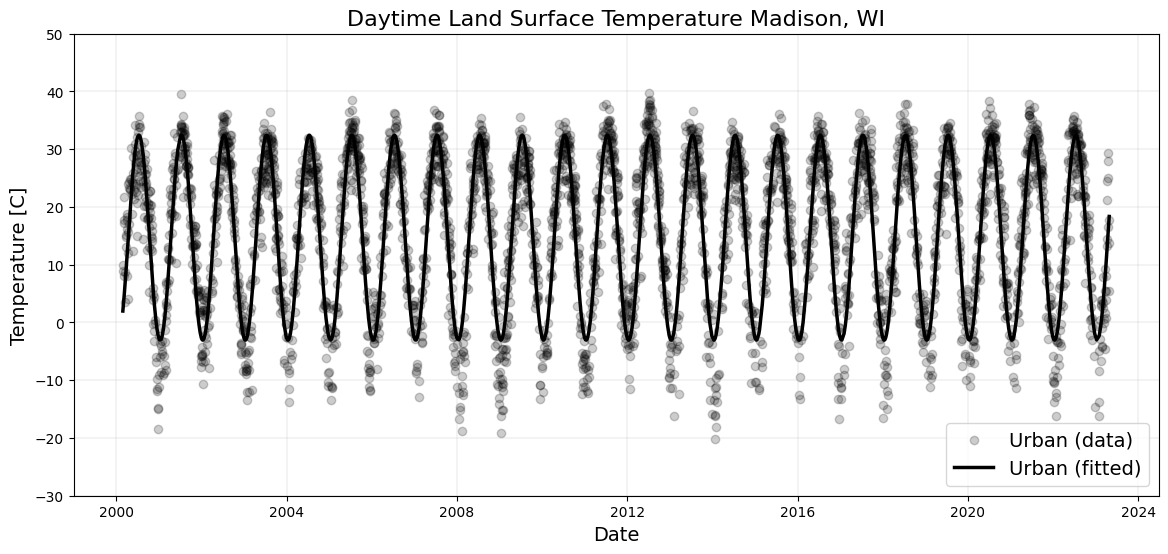

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['LST_Day_1km'].apply(float))  # urban

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['LST_Day_1km'],
           c='black', alpha=0.2, label='Urban (data)')

# Add fitting curves.
ax.plot(lst_df_urban['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Urban (fitted)', color='black', lw=2.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Madison, WI', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-30, 50)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()